In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Frame dimensions
x_min, x_max = -100, 100
y_min, y_max = -100, 100

# Define pillar dimensions
pillar_width = 0.6 * (x_max - x_min)
pillar_height = 0.25 * (y_max - y_min)

# Calculate pillar bounds
pillar_x_min = x_min
pillar_x_max = x_min + int(pillar_width)
pillar_y_min = y_min + (y_max - y_min) // 2 - int(pillar_height / 2)
pillar_y_max = pillar_y_min + int(pillar_height)

pillar = (pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max)

def is_inside_pillar(x, y, pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max):
    return (pillar_x_min <= x < pillar_x_max) and (pillar_y_min <= y < pillar_y_max)

def is_oob(x, y, x_min, x_max, y_min, y_max):
    return (x < x_min or x > x_max) or (y < y_min or y > y_max)

def generate_trajectories(num_trajectories, num_steps, x_min, x_max, y_min, y_max):
    trajectories = []

    while len(trajectories) < num_trajectories:
        while True:
            # Start position
            x_start = np.random.uniform(x_min, x_max)
            y_start = np.random.uniform(y_min, y_max)
            if not is_inside_pillar(x_start, y_start, pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max):
                break  # Valid start point found

        trajectory = [(x_start, y_start)]

        for _ in range(num_steps - 1):
            while True:
                # New position steps
                x_new = trajectory[-1][0] + np.random.normal(0, 1) * 10 # Multiply to increase step length
                y_new = trajectory[-1][1] + np.random.normal(0, 1) * 10

                # Check if the new point is within bounds and outside the pillar
                if not is_oob(x_new, y_new, x_min, x_max, y_min, y_max) and not is_inside_pillar(x_new, y_new, pillar_x_min, pillar_x_max, pillar_y_min, pillar_y_max):
                    trajectory.append((x_new, y_new))
                    break  # Valid point found, exit loop
        
        trajectories.append(trajectory)

    return np.array(trajectories)

In [8]:
# Parameters
num_trajectories = 50
num_steps = 300

# Generate valid trajectories
valid_trajectories = generate_trajectories(num_trajectories, num_steps, x_min, x_max, y_min, y_max)

def show_trajectories(valid_trajectories):
    plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max]) # Frame

    plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='red', alpha=0.5) # "Pillar"

    # Plot valid trajectories
    for count, trajectory in enumerate(valid_trajectories):
        plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label=f"Trajectory {count}")

    plt.title("Valid Trajectories with 'Blocked Area'")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

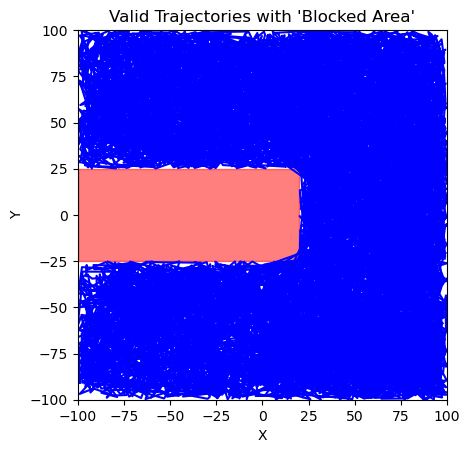

In [9]:
show_trajectories(valid_trajectories)

Epoch 0, Loss: 127.4214
Epoch 50, Loss: 94.9455
Epoch 100, Loss: 94.9068
Epoch 150, Loss: 94.8958
Epoch 200, Loss: 94.8880
Epoch 250, Loss: 94.8813
Epoch 300, Loss: 94.8757
Epoch 350, Loss: 94.8709
Epoch 400, Loss: 94.8663
Epoch 450, Loss: 94.8609
Epoch 500, Loss: 94.8558
Epoch 550, Loss: 94.8513
Epoch 600, Loss: 94.8467
Epoch 650, Loss: 94.8413
Epoch 700, Loss: 94.8361
Epoch 750, Loss: 94.8309
Epoch 800, Loss: 94.8255
Epoch 850, Loss: 94.8197
Epoch 900, Loss: 94.8134
Epoch 950, Loss: 94.8070
Epoch 1000, Loss: 94.7999
Epoch 1050, Loss: 94.7922
Epoch 1100, Loss: 94.7848
Epoch 1150, Loss: 94.7764
Epoch 1200, Loss: 94.7676
Epoch 1250, Loss: 94.7595
Epoch 1300, Loss: 94.7509
Epoch 1350, Loss: 94.7408
Epoch 1400, Loss: 94.7315
Epoch 1450, Loss: 94.7246
Epoch 1500, Loss: 94.7146
Epoch 1550, Loss: 94.7095
Epoch 1600, Loss: 94.6942
Epoch 1650, Loss: 94.6862
Epoch 1700, Loss: 94.6832
Epoch 1750, Loss: 94.6713
Epoch 1800, Loss: 94.6666
Epoch 1850, Loss: 94.6588
Epoch 1900, Loss: 94.6421
Epoch 19

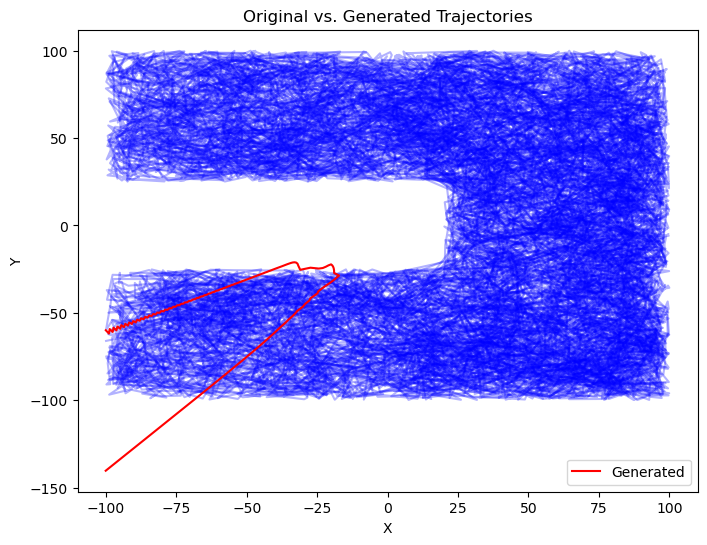

In [11]:
# Function to compute velocity field from trajectories
def compute_velocity_field(trajectories, dt=1.0):
    velocities = (trajectories[:, 1:, :] - trajectories[:, :-1, :]) / dt
    midpoints = (trajectories[:, 1:, :] + trajectories[:, :-1, :]) / 2
    return midpoints, velocities

# Generate trajectories (assuming valid_trajectories is already generated)
num_trajectories, num_steps, _ = valid_trajectories.shape
midpoints, velocities = compute_velocity_field(valid_trajectories)

# Flatten data for training
x_train = midpoints.reshape(-1, 2)
v_train = velocities.reshape(-1, 2)
x_train, v_train = torch.tensor(x_train, dtype=torch.float32).to(device), torch.tensor(v_train, dtype=torch.float32).to(device)

# Define flow matching model
class FlowMatchingModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

# Instantiate model, loss function, and optimizer
model = FlowMatchingModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()
    v_pred = model(x_train)
    loss = criterion(v_pred, v_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Function to sample new trajectories using trained model
def sample_trajectory(model, x0, num_steps=300, dt=1.0):
    model.eval()
    trajectory = [x0]
    x = torch.tensor(x0, dtype=torch.float32).to(device)
    with torch.no_grad():
        for _ in range(num_steps - 1):
            v = model(x.unsqueeze(0)).squeeze(0)
            x = x + v * dt
            trajectory.append(x.cpu().numpy())
    return np.array(trajectory)

# Test the learned flow
x0 = np.array([-100.0, -60.0])  # Start point
new_trajectory = sample_trajectory(model, x0)

# Plot original and generated trajectories
plt.figure(figsize=(8, 6))
for traj in valid_trajectories:
    plt.plot(traj[:, 0], traj[:, 1], color='blue', alpha=0.3)
plt.plot(new_trajectory[:, 0], new_trajectory[:, 1], color='red', label='Generated')
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Original vs. Generated Trajectories")
plt.show()